## 4. Explicabilidad del modelo:

### Importo librerías:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import time
import shap
import pickle

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Lectura de datos:

In [2]:
# Importamos el conjunto de datos tras el feature engineering:
df_fraud_final = pd.read_csv("../data/final_fraud_dataframe.csv").drop("Unnamed: 0", axis = 1)

In [3]:
# Hacemos un One-Hot Encoding de las variables categóricas para poder usar la función de regresión lineal de Lasso con el
# fin de entender la importancia de cada variable:
categoricals_list = ['device_os', 'source', 'housing_status', 'employment_status', 'payment_type']
ohe = ce.OneHotEncoder(cols = categoricals_list)

model = ohe.fit(df_fraud_final, df_fraud_final["fraud_bool"])
model

OneHotEncoder(cols=['device_os', 'source', 'housing_status',
                    'employment_status', 'payment_type'])

In [4]:
# Transformamos las variables categóricas usando el fit y el transform del ColumnTransformer:

ohe_transform = ColumnTransformer(transformers = [('category', OneHotEncoder(), categoricals_list)], 
                                  remainder = 'passthrough')

# Creamos un nuevo dataframe con los datos del one-hot encoding ya que este encoding sirve solamente para poder usar la 
# función de Lasso, de manera controlamos que no se corrompa el dataframe del conjunto de datos original:
df_ohe = pd.DataFrame(ohe_transform.fit_transform(df_fraud_final),
                      columns = ohe_transform.get_feature_names_out(df_fraud_final.columns))

df_ohe = df_ohe.drop("category__source_INTERNET", axis = 1)

In [5]:
# Creando el conjunto de datos de X_test:
X = df_fraud_final.drop("fraud_bool", axis = 1)
Y = df_fraud_final.fraud_bool

X_train_0, X_test, y_train_0, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

### Lectura de modelo final:

In [6]:
with open('gradient_boosting_model.pkl', 'rb') as fraud_prediction_model:
    loaded_clf = pickle.load(fraud_prediction_model)

In [7]:
loaded_clf.named_steps['classifier'].feature_importances_

array([5.63324396e-02, 8.19514129e-03, 5.54169619e-02, 1.03252170e-01,
       7.41366190e-04, 3.73021531e-04, 1.32528869e-01, 3.48913449e-02,
       4.12096379e-02, 2.61969572e-03, 2.30524038e-02, 3.96624717e-05,
       6.54715334e-07, 3.11696714e-02, 1.20780429e-02, 5.45036709e-03,
       6.81524913e-04, 2.94815690e-04, 1.36598196e-03, 4.32233010e-05,
       3.49839676e-02, 1.91963673e-02, 3.20384040e-02, 1.15033657e-02,
       9.97380658e-07, 4.14434200e-03, 8.67115952e-03, 1.84211991e-02,
       3.77847476e-02, 5.73165152e-03, 1.82738708e-03, 3.87563304e-04,
       1.12072589e-03, 1.78075829e-02, 2.73380175e-02, 2.50367027e-02,
       2.88317922e-02, 1.64261332e-02, 1.70702490e-02, 4.21788957e-02,
       1.28647122e-02, 1.86655086e-02, 6.28515226e-03, 5.08235192e-03,
       7.83443794e-03, 6.37209437e-02, 1.40818037e-02, 1.12268418e-02])

### Explicabilidad del modelo usando valores SHAP:

In [8]:
shap.initjs()

In [9]:
# Creando un objeto de tipo "TreeExplainer" de la librería de SHAP para el modelo de GradientBoostingClassifier() que tuvo
# mejor rendimiendo en la función de RandomizedSearchCV() al hacer la busqueda de los hiperparámetros ideales:

explainer = shap.TreeExplainer(loaded_clf.named_steps['classifier'])

# Este objeto de tipo "TreeExplainer" luego se usará para generar los valores SHAP que analizaremos a continuación

In [10]:
# Creando una lista de las variables categóricas y numéricas después de haberse aplicado el One-Hot Encoding ya que la
# el conjunto de datos que recibe la función de GradientBoostingClassifier() es la de después del One-Hot Encoding:

all_columns = list(df_ohe.drop(["remainder__fraud_bool"], axis = 1).columns)
print(len(all_columns))

48


In [11]:
# Creando un dataframe con el conjunto de datos que se usa en el modelo de Gradient Boosting ya que es lo que resulta del
# pipeline de "preprocessor", el cual incluye un One-Hot Encoding de variable categóricas y un Standard Scalar de variables
# numéricas:
downsampled_X = X_test.sample(n = 200, random_state = 42)

test_data = pd.DataFrame.sparse.from_spmatrix(csr_matrix(loaded_clf['preprocessor'].transform(downsampled_X))) # cambiar clf por clf_1 si no funciona

In [12]:
# Visualizando la tabla de datos:
test_data.columns = all_columns
test_data.head()

category__device_os_linux  category__device_os_macintosh  \
0                        1.0                            0.0   
1                        1.0                            0.0   
2                        1.0                            0.0   
3                        0.0                            0.0   
4                        0.0                            0.0   

   category__device_os_other  category__device_os_windows  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          1.0   
4                        1.0                          0.0   

   category__device_os_x11  category__source_TELEAPP  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   

   category__housing_status_BA  category__housing_status_BB  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          1.0   
4                          0.0                          0.0   

   category__housing_status_BC  category__housing_status_BD  ...  \
0                          1.0                          0.0  ...   
1                          0.0                          0.0  ...   
2                          0.0                          0.0  ...   
3                          0.0                          0.0  ...   
4                          0.0                          0.0  ...   

   remainder__email_is_free  remainder__income  \
0                  0.941897          -1.593753   
1                  0.941897          -0.215890   
2                  0.941897           0.473041   
3                  0.941897           0.817507   
4                  0.941897          -1.593753   

   remainder__date_of_birth_distinct_emails_4w  \
0                                     0.893131   
1                                    -0.298629   
2                                     1.489011   
3                                     0.495878   
4                                    -0.100002   

   remainder__bank_branch_count_8w  remainder__velocity_4w  \
0                        -0.396583                0.274355   
1                        -0.383529                1.503424   
2                        -0.400934                1.299804   
3                        -0.400934                0.759827   
4                        -0.398758               -0.564230   

   remainder__velocity_24h  remainder__days_since_request  \
0                 1.586258                      -0.187333   
1                -0.369425                      -0.187039   
2                 0.953005                      -0.183167   
3                 0.792914                      -0.190275   
4                 0.334661                      -0.183946   

   remainder__customer_age  remainder__name_email_similarity  remainder__month  
0                -1.137634                         -1.335716         -0.583487  
1                 0.524788                          1.185337         -1.488504  
2                 1.355999                          0.171533         -1.488504  
3                -1.137634                          0.784396         -0.583487  
4                -1.137634                         -0.024953          1.226548  

[5 rows x 48 columns]

In [13]:
# Creando los valores de shap de cada variable para cada instancia:
start_time = time.time()

shap_values = explainer.shap_values(test_data)

end_time = time.time()
elapsed_time = end_time - start_time

print("____")
print(f"Elapsed time: {elapsed_time/60/60} hours")
print(f"Elapsed time: {elapsed_time/60} minutes")

____
Elapsed time: 0.2000677906142341 hours
Elapsed time: 12.004067436854045 minutes


In [15]:
# Visualizando los valores de shap:
shap_values

array([[-4.30877504e-01, -8.39568093e-03,  2.93332076e-02, ...,
        -4.36088786e-01,  1.09234957e-01, -3.17448536e-02],
       [-4.54338062e-01, -6.97432289e-03,  6.36441387e-03, ...,
        -7.34457380e-02, -1.19420932e-01, -8.54661635e-03],
       [-4.35673016e-01, -1.03718846e-02,  9.66166767e-03, ...,
         3.04689555e-02, -1.07441878e-01, -8.71291764e-03],
       ...,
       [ 1.01910789e-01, -1.22615371e-02,  6.78703510e-02, ...,
        -1.24282715e-01,  1.45149418e-01, -9.84070009e-03],
       [ 8.13307271e-02, -1.53566891e-04,  7.18256797e-02, ...,
        -1.67988013e-01, -1.23695998e-01, -5.04060976e-02],
       [ 2.86865292e-02, -8.12168273e-03, -2.32615836e-01, ...,
        -3.44707490e-01, -1.00450293e-01, -5.47239854e-02]])

In [16]:
test_data.iloc[0].tail()

remainder__velocity_24h             1.586258
remainder__days_since_request      -0.187333
remainder__customer_age            -1.137634
remainder__name_email_similarity   -1.335716
remainder__month                   -0.583487
Name: 0, dtype: Sparse[float64, 0]

In [17]:
# La cantidad de variables afectando cada predicción de fraude:
len(shap_values[0])

48

In [18]:
# La cantidad de predicciones de fraude:
len(shap_values[:, 0])

200

In [19]:
explainer.expected_value[0]

-0.06736397148485872

In [20]:
# Visualizando la explicación de porque la primera predicción es de no fraude:
shap.force_plot(explainer.expected_value[0], shap_values[0], test_data.iloc[0])

El gráfico de arriba usa los 48 valores shap de la primera instancia (existe un valor de shap por cada variable para cada instancia, por lo tanto, le afectan 48 valores de shap a cada instancia del conjunto de datos) para explicar porque se ha predecido que esa instancia en específico no es de fraude. El gráfico nos muetra como cada categoría de cada variable categórica y como cada variable numérica ha contribuido a esta predicción, ilustrando a las variables que han contribuido a que la predicción sea de "1" (fraude) en rosa y a las variables que han contribuido a que la predicción sea de "0" (no fraude) en azul. Las variables en rosa incrementan el valor final de f(x) mientras que los valores en azul lo bajan, por lo tanto, como f(x) es igual a -3.75, podemos ver que, al final, el modelo predice que esta instancia en específico es de no fraude, o igual a "0".

Como podemos ver, la categoría de "windows" de la variable categórica de "device_os" ha sido la variable con más importancia en la decisión final de esta predicción, bajando la probabilidad de que la instancia haya sido de fraude dado a que esta colorada en azul. Hay que considerar que la columna ha pasado por un one-hot encoding y que, por lo tanto, un valor de cero significa que el usuario no ha usado un ordenador de windows para registrarse. Teniendo esto en cuenta, podríamos concluir que, de esta manera, usuarios que no esten usando un ordenador de windows serán menos probables de cometer fraude.

De la misma manera, podemos ver que la variable numérica de "name_email_similarity" es la más significativa de las variables que incrementan la probabilidad de fraude en esta instancia. Por esta razón, podriamos concluir que, en el modelo, los usuarios que tienen menos similaridad entre sus nombres y los nombres de sus emails que la media de los usuarios del conjunto de datos (ya que tiene un valor de -1.336 tras la estandarización de la columna) tienen una probabilidad más alta de cometer fraude.

Es importante comentar que este gráfico solo indica la importancia de las variables al predecir fraude a nivel local. A continuación hay un gráfico usando valores SHAP que indica la importancia de las variables al predecir fraude a nivel global.

In [21]:
# Visualizando la importancia de todas la variables que se han usado para entrenar el modelo para hacer las predicciones de
# fraude:

shap.force_plot(explainer.expected_value[0], shap_values[: 50], features = test_data.iloc[: 50])

En el gráfico de arriba podemos ver un gráfico que indica la importancia de las variables al predecir fraude a nivel global. Este gráfico en específico tiene el valor de f(x) como el eje y y las instancias del conjunto de datos como el eje x. El gráfico ha agrupado a las 50 instancias del conjunto de datos con más similitudes en función de los valores de las variables. Podemos ver que de estas 50 instancias, ninguna se ha considerado como fraude ya que ninguna instancia tiene un valor de f(x) más alto que cero. Esto refleja los resultados del modelo y de la realidad, dado que en el conjunto original de datos existía solo un porcentaje de fraude de alrededor del 2%, por lo que la gran mayoría de instancias no iban a ser predecidas como con fraude.

En todo caso, aunque el modelo haya predecido que ninguna de estas 50 instancias tienen fraude, es importante comentar como cambia el gráfico a lo largo de la eje x. Podemos ver que la instancia de número 43 tienen un valor de f(x) de 0.8206, mientras que el resto de las instancias tienen un valor de f(x) negativo. Esta instancia es la única en el conjunto que se ha ilustrado que se ha clasificado como con fraude, con el resto siendo todas clasificadas como sin frauda ya que es la única que tiene un valor de f(x) mayor a cero.

La instancia número 39 es la única otra instancia que se acerca un poco al valor de f(x) igual a cero, con un valor de f(x) de -1.11. Esto refleja que hay instancias que es posible que tengan características más relevantes al fraude y que si el threshold que hemos usado en el modelo se bajara aún más, estas instancias seguramente podrían ser clasificadas como fraude.

Tambien es importante comentar que como el threshold que hemos usado ya es el que maximiza el valor de f1 del modelo, aunque pudieramos incrementar la cantidad de instancias predecidas con fraude al bajar el threshold, es posible que estas predicciones sean falsos positivos y que, por lo tanto, no sea la decisión más óptima.

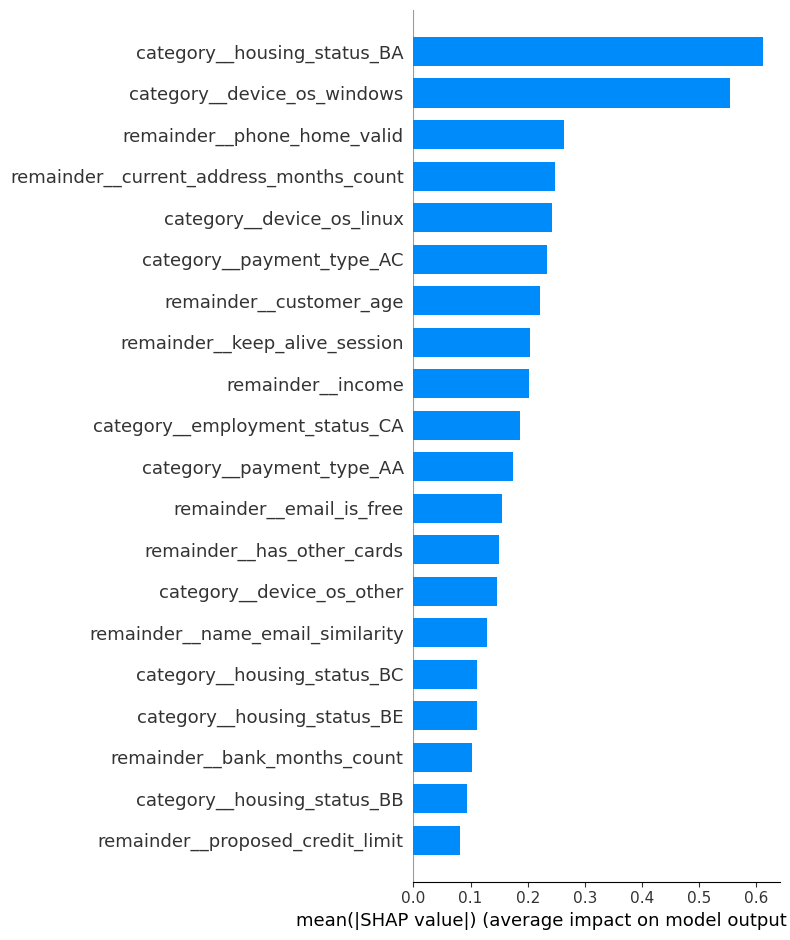

In [22]:
shap.summary_plot(shap_values, features = test_data, feature_names = all_columns, plot_type = "bar")

El gráfico de arriba indica la importacia de las variables a un nivel global. Podemos ver por el eje y que las variables más arriba del gráfico son las que más influencia tienen al predecir si las instancias del modelo tienen fraude o no. El eje x describe la media del impacto de cada variable sobre los resultados de las predicciones de fraude o no fraude. Como podemos ver, las barras tienen un color azul además de un color rojo. El color rojo refleja la magnitud del impacto de cada variable para que el resultado sea de instancias con fraude mientras que el color azul refleja la magnitud del impacto de cada variable para que el resultado sea de instancias sin fraude.

Hay que comentar que después de muchos intentos no hemos conseguido que el gráfico incluya la influencia que tienen las variables en clasificar instancias como con fraude (lo que en teoría saldría en rosa), pero que en teoría se supone que el gráfico tendría que no solo mostrar la influencia que tienen las variables para que las instancias se clasifiquen como sin fraude.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


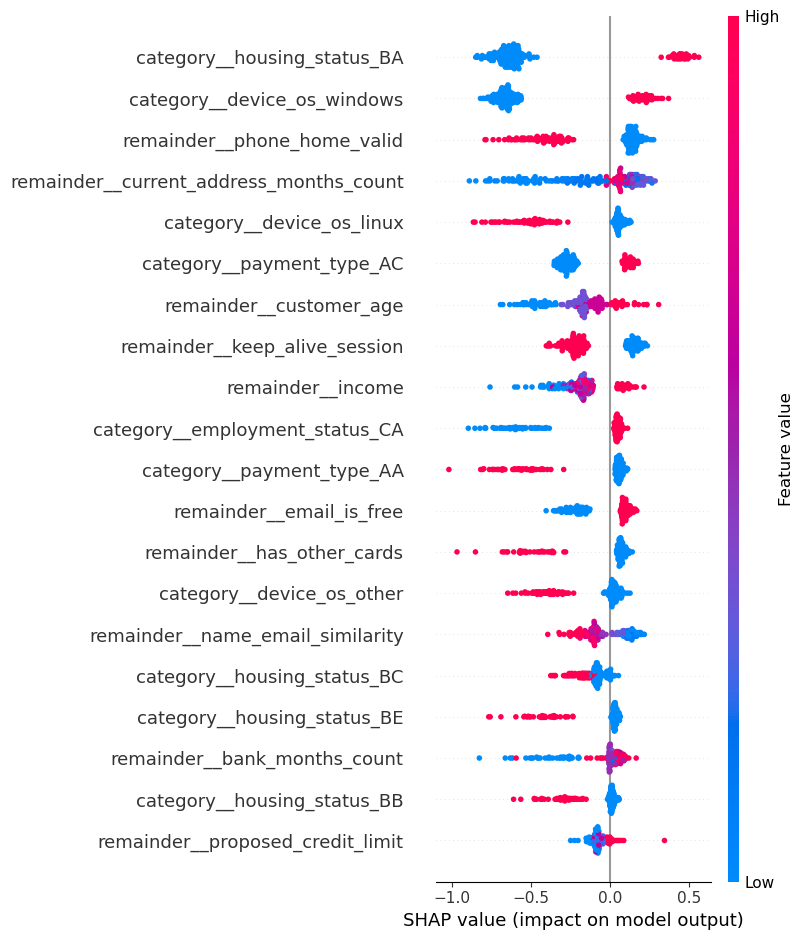

In [23]:
shap.summary_plot(shap_values, features = test_data, feature_names = all_columns, plot_type = "dot")

EL gráfico de arriba indica la importancia de cada variable a un nivel global de una manera similar a el gráfico anterior. El eje y representa la importancia de las variables de manera que las variables que se encuentran más arriba son las más importantes para el análisis y predicción de fraude. El eje x representa los valores SHAP, de manera que los valores SHAP positivos incrementan la probabilidad de que una instancia sea clasificada como fraude mientras que los valores SHAP negativos bajan la posibilidad de que una instancia sea clasificada como sin fraude. Lo más lejos el valor SHAP de cero, lo más impactante es sobre la predicción final de si una instancia tiene fraude o no. Cada punto en el gráfico representa una instancia del conjunto de datos, por lo que podemos ver que donde hay muchos puntos agrupados con un valor de SHAP de -4.5, por ejemplo, significa que esa variable en específico en general tiene una importancia significativa al influir en que las instancias del conjunto de datos sean clasificadas como sin fraude. Lo mismo se podría comentar en vice versa, si muchos puntos estuvieran agrupados en una variable con un valor de SHAP de más o menos 4.5, por ejemplo, significaría que esa variable en específico tiene una importancia significativa al influir en que las instancias del conjunto de datos sean clasificadas como con fraude.

Podemos ver, por ejemplo, que la categoría de "BA" de la variable categórica de "housing_status" es en general la más importante del modelo (algo que se corrobora al ver el gráfico anterior). Pero más específicamente, podemos ver como a la mayoría de las instancias del conjunto de datos les influye significativamente para que sean clasificadas como sin fraude ya que muchos puntos se encuentran agrupados alrededor de más o menos un valor de SHAP de -0.6. De la misma manera, también podemos ver que esta misma categoría de "BA" de la variable de "housing_status" también influye en que varias instancias del conjunto de datos sean clasificadas como con fraude, teniendo también un grupo de puntos agrupado alrededor de más o menos un valor de SHAP de 0.4 (aunque este grupo es mucho más pequeño que el anterior).